# SPS Machine Learning Tutorial, Part 1
---
January 29/30, 2020 // Luc Le Pottier, University of Michigan


##### first: a cool viz which didn't fit last time
just because I didn't have time, here's another cool way of visualizing dimensional data.

Here we will show a cool method of transforming sound files (.wav), which are in the amplitude-time domain, to the frequency-time domain. 

First we get some .wav files: 

In [1]:
!wget -q https://github.com/luclepot/SPS_ml_tutorial/raw/master/data/synths/SYNTH-FancyPoly800Dazed.wav https://github.com/luclepot/SPS_ml_tutorial/raw/master/data/synths/SYNTH-PWMRezzzzzzz.wav
!ls *.wav

SYNTH-FancyPoly800Dazed.wav  SYNTH-PWMRezzzzzzz.wav


Then we can make what is called a spectrogram; basically, an image of the behavior of the .wav file in time, as a function of intensity.

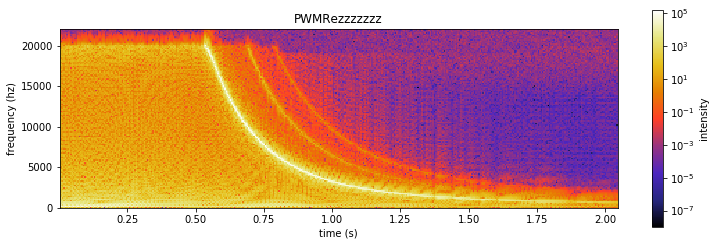

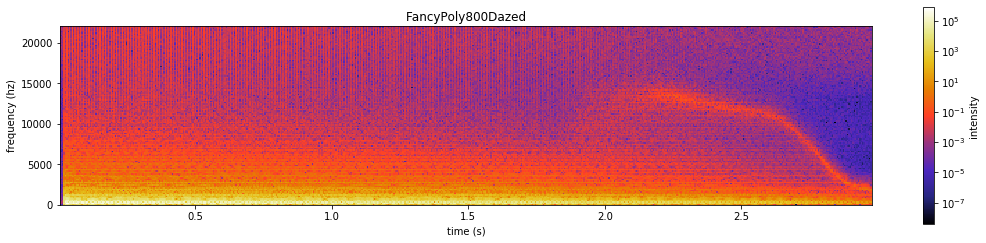

In [2]:
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt 
import matplotlib.colors as plt_colors
import glob

filenames = glob.glob('SYNTH-*.wav')
for path in filenames:
    
    name = path.split('-')[-1].replace('.wav', '')
    sample_rate, data = scipy.io.wavfile.read(path)
    f,t,Sxx = scipy.signal.spectrogram(data, fs=sample_rate, return_onesided=True)

    plt.figure(figsize=(4*len(t)/len(f),4))
    plt.pcolormesh(t, f, Sxx, cmap='CMRmap', norm=plt_colors.LogNorm())
    plt.colorbar().set_label('intensity')

    plt.ylabel('frequency (hz)')
    plt.xlabel('time (s)')
    plt.gca().set_aspect(t.max()/f.max() * len(f)/len(t))
    plt.title(name)
    plt.show()


## 1. Processing Data

As I probably made exceedingly clear, building a machine learning model is in large part about getting good data. Therefore, lets grab some data first:

In [0]:
!wget https://github.com/luclepot/SPS_ml_tutorial/raw/master/data/jets.h5 -q

Nice. We can load the data using h5, which we should have learned yesterday. Here's how to do it, but I encourage anyone to try it themselves first!

In [4]:
import h5py

f = h5py.File('jets.h5', 'r')

print(list(f.keys()))

['event_features', 'jet_eflow_variables', 'jet_features']


We can see there are a few datasets in this h5 file. We just want the `jet_features` column for now, which appears to be a group:

In [5]:
print(f['jet_features'])
print(list(f['jet_features'].keys()))

<HDF5 group "/jet_features" (2 members)>
['data', 'labels']


We can load the entirety of these datasets into memory because they are small, with the `labels` key being the columns of the set:

In [6]:
import pandas as pd

data_raw = f['jet_features']['data'][:] 
columns = f['jet_features']['labels'][:]
data_raw.shape, columns

((7406, 2, 9),
 array([b'Eta', b'Phi', b'Pt', b'M', b'ChargedFraction', b'PTD', b'Axis2',
        b'Flavor', b'Energy'], dtype='|S15'))

##### What is this data? 
Good question. This is data on individual jets at the LHC, with 9 attributes each per jet. 

##### What is a jet?
also a good question. Jets are analysis objects produced at LHC detectors.

the heavy and unstable results of high-energy particle collisions, i.e. the higgs boson or a top quark, decay rapidly after they are produced. So rapidly, in fact, that they do not make it anywhere close to the actual detectors!

Instead, these (and other) particles *shower*, or decay into various other hadrons (hadronization!). These hadrons then often decay as well, forming a cone of decay products. 

This cone of decay products - usually hadrons, electrons, and photons - is then intercepted by detectors, and it must be inferred what original particle generated these resultant particles. 

This is a *very* difficult problem, and an active field of research (my field of research!!)

##### What are we doing with this data?
These data points are from QCD (quark and gluon-produced) jets with very specific characteristics; namely, we have the leading and subleading (first and second highest transverse momentum, or $p_T$) jets for a number of events.

A good way to learn machine learning is to build a model. In this case, we can try to build a model to detect gluon jets from others. Using the $P,~T,~E$ characterization from the lecture slides, we can define this task as:
* *$P$*: high true positive rate, low false positive rate 
* *$T$*: discriminating between gluon and non-gluon jets
* *$E$*: jet samples containing some observables; in our case, these are
    * $p_T$, jet transverse momentum
    * $M$, jet invariant mass
    * Fraction of charged particles in jet
    * $PTD$, a complex jet quantity that I will not attempt to describe
    * $Axis^2$, ditto above
    * $E$, jet energy
    

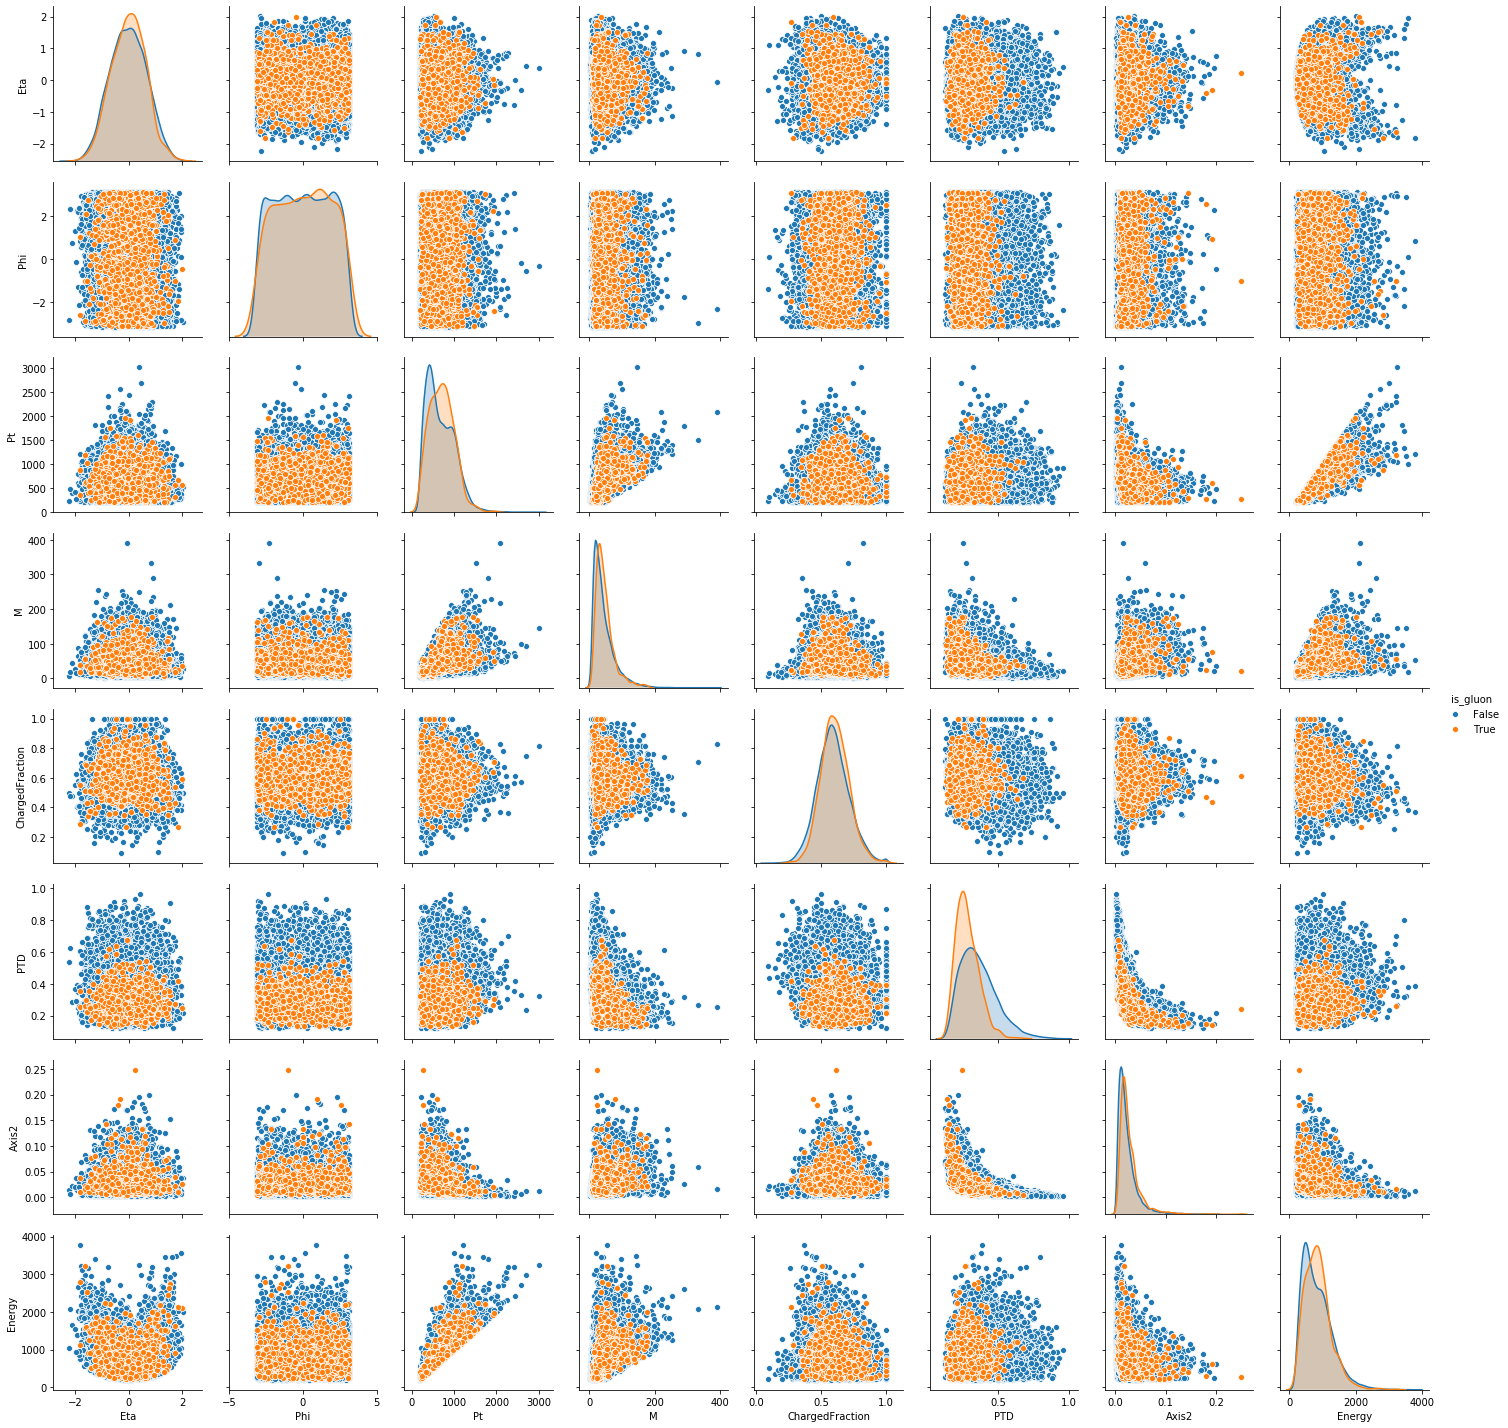

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# reshape the data so it is all jets, and decode the feature labels
data = pd.DataFrame(data_raw.reshape((7406*2, 9)), columns=map(lambda x: x.decode('utf-8'), columns))

# isolate gluon tags, make them the y-axis
y = data['Flavor'].isin([9, 21])
data['is_gluon'] = y
y = y.astype(int)

# remove flavor
data.drop(['Flavor'], axis=1, inplace=True)

# plot according to gluon status
sns.pairplot(data, hue='is_gluon', vars=[c for c in data.columns if c != 'is_gluon'])
data.drop('is_gluon', axis=1, inplace=True)
plt.show()

##### **These categories look similar!!**

That's fine - a lot of times structural information is not easily represented by human-readable visualizations. What we CAN see, though, is that $\eta$ and $\phi$ don't seem to provide much value - in fact, they are both randomly distributed (to within the limits of our small sample size)!

Lets remove them:

In [0]:
data.drop(['Eta', 'Phi'], axis=1, inplace=True)

## **2. Building a Model**

For demonstration, we want to first try and use a nice neural network to discriminate between these two categories. While We are aware that this might not work, let's go through the steps of building one!

First, we import keras. This is a *wrapper* library for tensorflow (a tensor library). Keras makes implementing neural networks much easier, but it is less configurable (will be important when you are making super-ultra-mega-GAN-CONVnets in a month) 

In [0]:
import keras
import warnings
import seaborn
warnings.filterwarnings("ignore")

Keras is great. The main parts of it, which you will need to know, are:
* **`keras.layers`**: the layer-containing module, in which prebuilt layers are contained
* **`keras.models`**: model-containing part of keras; how you build your models. 

Below I will build a simple neural network, using layer and model blocks from these libraries:

In [0]:
iris = sns.load_dataset('iris')
x = iris.drop('species', axis=1)
encoding_dict = {name: i for i,name in enumerate(iris.species.unique())}
y = iris['species'].apply(lambda i: encoding_dict[i])
y = keras.utils.np_utils.to_categorical(y)

# input layer with shape equivalent to the number of features in our dataset
input_layer = keras.layers.Input(shape=(len(x.columns),), name='inputs')

# hidden layer with 20 neurons, and relu activation
hidden_layer1 = keras.layers.Dense(10, activation='relu', name='hidden_1')

# output layer with softmax activation
output_layer = keras.layers.Dense(y.shape[1], activation='softmax', name='output')

NOTE that we have only defined the layer blocks, and not connected any tensors!

Tensors can be connected to one another by feeding them into each other as function arguments. This is a bit confusing, so watch:

In [0]:
current = input_layer
current = hidden_layer1(current) # feed input into hidden layer
output = output_layer(current) # 

Now we have chained the tensors together, and have an input and output. We can now connect these in a meaningful way with the `Model` class:

In [205]:
nn = keras.models.Model(inputs=input_layer, outputs=output)
nn.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 4)                 0         
_________________________________________________________________
hidden_1 (Dense)             (None, 10)                50        
_________________________________________________________________
output (Dense)               (None, 3)                 33        
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


In addition to the 'summary' function, we can print a cool graphic of the model:

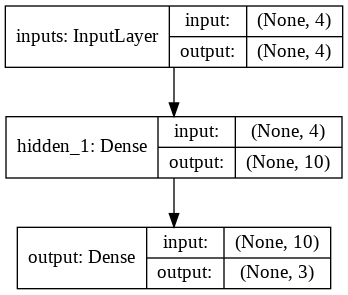

In [206]:
from keras.utils import plot_model
plot_model(nn, to_file='arch.png', show_layer_names=True, show_shapes=True)

## **3: Training a model**

This is the fun (and sometimes annoying part): training the model. The model first has to be compiled, and then fit.


In [0]:
nn.compile(optimizer=keras.optimizers.adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

To fit the model, we need to split out data into training and testing samples. This is because models - especially big ones - are prone to memorize all samples in a small training set, and ours is not very big. 

A model which works on memorization, not generalization, is usually very bad and cannot do well on a test set. For this reason, we should split it.

In [208]:
from sklearn.model_selection import train_test_split

# we gotta split our labels too!
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(90, 4) (60, 4)
(90, 3) (60, 3)


Now we can train! For this we use the `fit` function of the model:

In [0]:
history = nn.fit(x_train, y_train, epochs=200, validation_split=0.2, verbose=False)

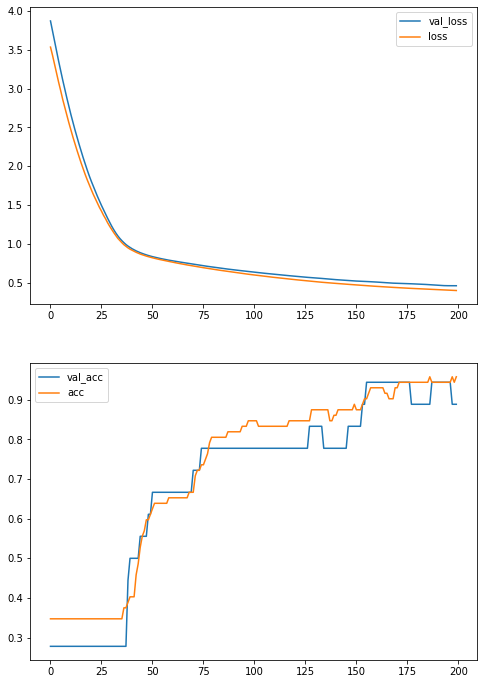

In [210]:
fig,axs = plt.subplots(2,1,figsize=(8,12))
for key,value in history.history.items():
    if key.endswith('loss'):
        axs[0].plot(value, label=key)
    else:
        axs[1].plot(value, label=key)

axs[0].legend()
axs[1].legend()

In [213]:
score, accuracy = nn.evaluate(x_test, y_test)
print('test score: ', score)
print('test accuracy: ', accuracy)

60/60 [==============================] - 0s 134us/step
test score:  0.3907460073630015
test accuracy:  0.9666666746139526
